In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import torch
import torch.nn as nn
import json
import os

from feature_extractor import FeatureExtractor


In [2]:
ext_dict = pickle.load(open('/workspace/pvc-meteor/features/extraction_output_11-02-2023-18-33.pkl', 'rb'))
print(ext_dict['meta'])
anno_dict = ext_dict['annotations']
json_file = json.load(open('../../pvc-meteor/features/METEOR_info.json', 'r'))['METEOR']

CATEGORIES = ['OverTaking', 'LaneChange', 'WrongLane', 'Cutting']

INDICES = []
for i, name in enumerate(json_file['class_index']):
    if name in CATEGORIES:
        INDICES.append(i)

CAT_IND_DICT = dict(zip(CATEGORIES, INDICES))

{'fps': 2, 'rgb_extractor': 'SwinTransformer', 'flow_extractor': 'GMFlowNetModel', 'extraction_time': '11-02-2023-18-33'}


## get label distribution

In [5]:
total_frames = 0
cat_array = np.zeros((7,))
unannoted_frames = 0

for name in tqdm(anno_dict.keys()):
    total_frames += anno_dict[name]['feature_length']
    annotation = anno_dict[name]['anno']
    new_cat = np.sum(annotation, axis=0)
    unannoted_frames += anno_dict[name]['feature_length'] - np.any(annotation, axis=1).sum()

    cat_array = cat_array + new_cat


100%|██████████| 1213/1213 [00:00<00:00, 16073.99it/s]


In [6]:
cat_names = ['Over Taking', 'Over Speedign', 'Lane Change', 'Traffic Light', 'Wrong Lane', 'Wrong Turn', 'Cutting']

cat_array, total_frames, unannoted_frames

(array([2.81774e+05, 3.42000e+02, 9.05710e+04, 5.18000e+02, 3.65120e+04,
        2.13000e+02, 9.48200e+03]),
 985746,
 622239)

## visualize class distribution

Text(0.5, 1.0, 'Distribution of frames per category, Logscaled')

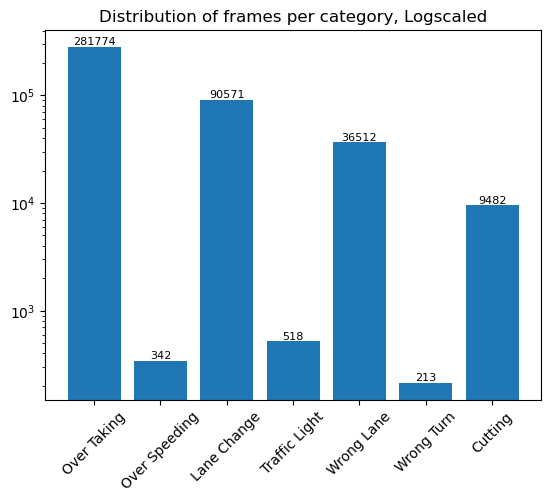

In [7]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.set_yscale('log')
cat_names = ['Over Taking', 'Over Speeding', 'Lane Change', 'Traffic Light', 'Wrong Lane', 'Wrong Turn', 'Cutting']


ax.bar(cat_names, cat_array)

# Add annotations to each bar
for bar in ax.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, 
            str(int(height)),
            ha='center', va='bottom', rotation=0, color='black', fontsize=8)

plt.xticks(rotation = 45)
plt.title('Distribution of frames per category, Logscaled')

### analyse test and train set seperately.

In [9]:
train_vid_names = json_file['train_session_set']
test_vid_names = json_file['test_session_set']

test_class_counts = np.zeros((7))
for vid_name in test_vid_names:
    curr_anno = anno_dict[vid_name]['anno']

    test_class_counts = test_class_counts + np.sum(curr_anno, axis=0)
    
train_class_counts = np.zeros((7))
for vid_name in train_vid_names:
    curr_anno = anno_dict[vid_name]['anno']

    train_class_counts = train_class_counts + np.sum(curr_anno, axis=0) 

,test_f,train_f,abs_frames,rel_test
OverTaking,57700.0,224074.0,281774.0,0.204774
Overspeeding,0.0,342.0,342.0,0.000000
LaneChange,17235.0,73336.0,90571.0,0.190293
TrafficLight,0.0,518.0,518.0,0.000000
WrongLane,6373.0,30139.0,36512.0,0.174545
WrongTurn,36.0,177.0,213.0,0.169014
Cutting,1998.0,7484.0,9482.0,0.210715


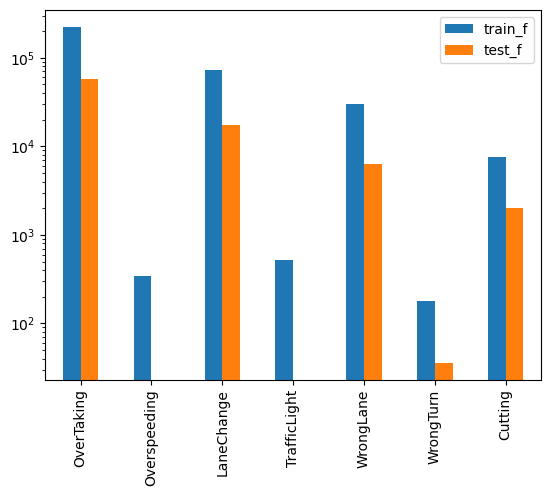

In [10]:
df = pd.DataFrame(
    data=np.column_stack((test_class_counts, train_class_counts)),
    columns=['test_f', 'train_f'],
    index = json_file['class_index']
)
'''
df = (df
    .assign(abs_frames = df['test_f'] + df['train_f'])
    .assign(rel_test = df['test_f'] / df['abs_frames'])
)
'''
df = df.assign(abs_frames = df['test_f'] + df['train_f'])
df = df.assign(rel_test = df['test_f'] / df['abs_frames'])



ax = df[['train_f', 'test_f']].plot(kind='bar', stacked=False)
ax.set_yscale('log')

df

### analyse frames per category and video

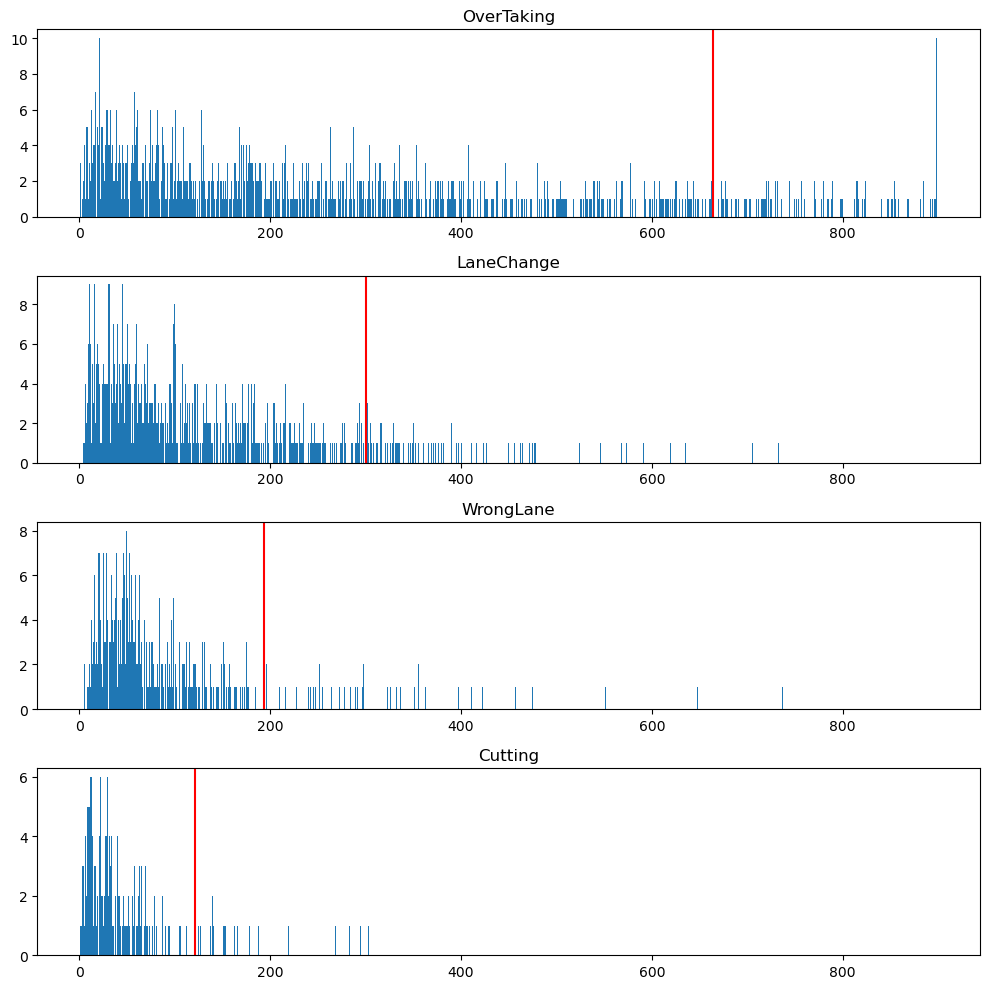

In [33]:
def get_anno_distribution(anno_data, info_json, categories):
    """get the distribution of labels per video

    Args:
        anno_data (dict): data file that contains the actual annotations.
        info_json (dict): info file, containing a 'class_index' key that corresponds to (ordered) list with all the class names of the data.
        categories (list): Categories that should be analyzed.

    Returns:
        pd.DataFrame: values are the summed frames per category and video, columns are the categories, indices the video names.
    """
    # transform categories to indices
    indices = []
    for i, name in enumerate(info_json['class_index']):
        if name in categories:
            indices.append(i)
    
    # get label_distribution per video:
    dist_df = pd.DataFrame(data=None, columns=categories)
    for name in anno_data.keys():
        anno_data = anno_dict[name]['anno'][:,indices].sum(axis=0)
        temp_df = pd.DataFrame(data = [anno_data], columns=categories, index = [name])
        dist_df = pd.concat([dist_df, temp_df], axis=0)
    
    return dist_df


df = get_anno_distribution(anno_dict, json_file, ['OverTaking', 'LaneChange', 'WrongLane', 'Cutting'])

fig, ax = plt.subplots(len(df.columns), 1, figsize=(10,10))

bins = np.arange(1, df.values.max() + 1)

for i, col in enumerate(df.columns):
    hist, bins = np.histogram(df.loc[df.loc[:,col] > 0, col], bins=bins)
    bin_width = bins[1] - bins[0]
    ax[i].hist(df.loc[df.loc[:,col] > 0, col], bins=bins)
    ax[i].axvline(np.percentile(df.loc[df.loc[:,col] > 0, col], 90), color='red')
    ax[i].set_title(col)

plt.tight_layout()

## propose new splits

In [12]:
def more_perfect_split(anno_data, info_json, categories, train_split = 0.8):
    # 1. select category with fewest samples
    # 2. split this category, so that 20% test; 80% train
    # 3. select next most infrequent category --> check if frames from this are already in train/test set
    # 4. split this category so that ~20% test; ~80% train
    # 5. if not all categories processed: back to 3; else: return set 
    dist_df = get_anno_distribution(anno_data, info_json, categories)

    # order columns by frequency --> infrequent first
    cat_by_freq = list(dist_df.sum().sort_values(ascending=True).index)

    # set up dataframe to store training data
    train_df = pd.DataFrame(data=None, columns=categories)

    # keep track of columns where 80% target is already satisfied
    satisfied_columns = []

    # iterate through categories, starting with most infrequent ones.    
    for cat in cat_by_freq:
        total_frames = dist_df.loc[:, cat].sum()
        abs_train_frames = int(total_frames * train_split)
        vid_list = list(dist_df.loc[dist_df.loc[:, cat] > 0, cat].index)

        # get cat_df 
        cat_df = dist_df.loc[vid_list,:].sort_values(cat, ascending=False)
        # filter cat_df: only keep videos that don't have frames for satisfied cats
        if len(satisfied_columns) > 0:
            cat_df = cat_df.loc[cat_df.loc[:, satisfied_columns].sum(axis=1) == 0, :]

        _idx = 0
        while train_df.loc[:, cat].sum() < abs_train_frames:
            train_df = pd.concat([train_df, pd.DataFrame(cat_df.iloc[_idx, :]).T], axis=0)

            # alternate between longest and shortest video to add.
            _idx = 0 if _idx == -1 else -1

        satisfied_columns.append(cat)

        # print(train_df.sum(axis=0).values / dist_df.sum(axis=0).values)
        return train_df


# df = more_perfect_split(anno_dict, json_file, ['OverTaking', 'LaneChange', 'WrongLane', 'Cutting'])

In [14]:
# needs improvement
def frame_equity_split(anno_data, json_file, categories, train_split = 0.8):
    # idea is we only pick 80% frames of the category with the fewest frames 
    # this number of frames determines how many frames we pick from all the other categories

    # df with distribution per frame
    dist_df = get_anno_distribution(anno_data, json_file, categories)

    # find category with fewest frames:
    total_train_frames = int(dist_df.sum().min() * train_split) # returns category name as string
    print('frames: ', total_train_frames)

    cat_by_freq = list(dist_df.sum().sort_values(ascending=True).index)

    # set up dataframe to store training data
    train_df = pd.DataFrame(data=None, columns=categories)

    # keep track of columns where 80% target is already satisfied
    satisfied_columns = []

    # iterate through categories, starting with most infrequent ones.    
    for cat in cat_by_freq:
        vid_list = list(dist_df.loc[dist_df.loc[:, cat] > 0, cat].index)

        # get cat_df 
        cat_df = dist_df.loc[vid_list,:].sort_values(cat, ascending=False)
        
        # filter cat_df: only keep videos that don't have frames for satisfied cats
        if len(satisfied_columns) > 0:
            cat_df = cat_df.loc[cat_df.loc[:, satisfied_columns].sum(axis=1) == 0, :]

        _idx = 0
        while train_df.loc[:, cat].sum() < total_train_frames:
            train_df = pd.concat([train_df, pd.DataFrame(cat_df.iloc[_idx, :]).T], axis=0)

            # alternate between longest and shortest video to add.
            _idx = 0 if _idx == -1 else -1

        satisfied_columns.append(cat)

        print(train_df.sum())
    # return train_df


min_frame_split(anno_dict, json_file, ['OverTaking', 'LaneChange', 'WrongLane', 'Cutting'])

frames:  7585
OverTaking    9725.0
LaneChange    5525.0
WrongLane        0.0
Cutting       7599.0
dtype: float64
OverTaking    16990.0
LaneChange    12143.0
WrongLane      8146.0
Cutting        7599.0
dtype: float64
OverTaking    16990.0
LaneChange    12143.0
WrongLane      8146.0
Cutting        7599.0
dtype: float64
OverTaking    16990.0
LaneChange    12143.0
WrongLane      8146.0
Cutting        7599.0
dtype: float64


In [15]:
# TODO: finish this
def balanced_background_split(anno_data, json_file, categories, train_split = 0.8):
    """select data so that in train set the background (empty features) is about as present as the rest of the categories.
    Follows the idea of 'more_perfect_split()' function to ensure 

    Args:
        anno_data (_type_): _description_
        json_file (_type_): _description_
        categories (_type_): _description_
        train_split (float, optional): _description_. Defaults to 0.8.
    """


    full_anno_dist = get_anno_distribution(anno_data, json_file, categories)
    perf_df = more_perfect_split(anno_data, json_file, categories, train_split)


In [29]:
df = get_anno_distribution(anno_dict, json_file, categories=['OverTaking', 'LaneChange', 'WrongLane', 'Cutting'])
background_names = list(df.loc[df.sum(axis=1) == 0, : ].index)

# count number of frames in train_session_set with and without background_names
all_frames, non_background_frames = 0, 0
for key in json_file['train_session_set']:
    key_length = anno_dict[key]['feature_length']
    all_frames += key_length
    if key not in background_names:
        non_background_frames += key_length
    
print(f'{all_frames} frames in total\n{non_background_frames} withouth background\n{all_frames - non_background_frames} backgound frames')

# how about density based split --> select videos with highes ratio of relevant frames/total frames first into train --> only keep adding videos while ratio of background/non-background frames is lower than 60/40

786303 frames in total
711509 withouth background
74794 backgound frames


## find pure examples for analysis reasons

### videos

In [14]:
pure_df = pd.DataFrame(
    data = np.zeros((len(CATEGORIES), 2)),
    columns = ['train', 'test'],
    index = CATEGORIES
)

for session_name in ['train', 'test']:
    session = f'{session_name}_session_set'
    for key in json_file[session]:
        annotation = anno_dict[key]['anno']
        sum_anno = np.any(annotation, axis=0)[indices].astype(int)
        if np.sum(sum_anno) != 1:
            continue
        else:
            i = int(np.argwhere(sum_anno))

            pure_df.loc[:,session_name].iloc[i] += 1
            
pure_df

,train,test
OverTaking,166.0,43.0
LaneChange,18.0,8.0
WrongLane,17.0,2.0
Cutting,4.0,2.0


### segments

find frames where only one category is present for t_0 --> how to provide these to the model?

In [34]:
pure_segment_df = pd.DataFrame(columns = ['vid_name', 'index', 'category'])

for key in json_file['test_session_set']:
    anno = anno_dict[key]['anno'][:, INDICES]
    anno_sum = np.sum(anno, axis=1)
    # get 'pure' indices 
    vid_i = np.where(anno_sum == 1)[0]
    # map index to categoriy

    cat_i = np.argmax(anno[vid_i], axis=1).astype(int)

    if len(cat_i) == 0:
        continue

    f = lambda x, d: d[x]
    vec_f = np.vectorize(f)
    cat_names = vec_f(cat_i, dict(zip(range(len(CATEGORIES)), CATEGORIES)))

    names = [key] * len(vid_i)

    append_data = np.column_stack((np.array(names), vid_i, np.array(cat_names)))
    append_df = pd.DataFrame(columns = ['vid_name', 'index', 'category'], data=append_data)
    pure_segment_df = pd.concat([pure_segment_df, append_df])
pure_segment_df

,vid_name,index,category
0,REC_2020_10_12_18_24_36_F.MP4,0,OverTaking
1,REC_2020_10_12_18_24_36_F.MP4,1,OverTaking
2,REC_2020_10_12_18_24_36_F.MP4,2,OverTaking
3,REC_2020_10_12_18_24_36_F.MP4,3,OverTaking
4,REC_2020_10_12_18_24_36_F.MP4,4,OverTaking
...,...,...,...
200,REC_2020_10_10_07_11_57_F.MP4,760,OverTaking
201,REC_2020_10_10_07_11_57_F.MP4,761,OverTaking
202,REC_2020_10_10_07_11_57_F.MP4,762,OverTaking
203,REC_2020_10_10_07_11_57_F.MP4,763,OverTaking


# analyse behaviour in terms of actors

used .csv file is generated using the action_analysis.py script.

In [12]:
action_df = pd.read_csv('actions_by_actors.csv', index_col=0)

print('frames_per_actor')
action_df.sum(axis=1).sort_values(ascending=False)

frames_per_actor


EgoVehicle             459018.0
Car                    435934.0
MotorBike              387874.0
Scooter                158836.0
Truck                   95482.0
MotorizedTricycle       86766.0
Bus                     51994.0
Van                      8518.0
Pedestrian               5606.0
Bicycle                  3775.0
Tractor                  2655.0
ConstructionVehicle      1068.0
Animal                    390.0
MultiWheeler              332.0
AgricultureVehicle          0.0
Pedestrain                  0.0
Tricycle                    0.0
TriCycle                    0.0
dtype: float64

it's evident that some actors are much more frequent to show aggressive driving behaviour --> selecting a subset of actors

In [13]:
action_df.sum(axis=1).sort_values(ascending=False).loc[action_df.sum(axis=1) > 100000]

EgoVehicle    459018.0
Car           435934.0
MotorBike     387874.0
Scooter       158836.0
dtype: float64

EgoVehicle is not relevant to the task at hand --> exclude from future selection

In [15]:
action_df.loc[action_df.sum(axis=1).loc[action_df.sum(axis=1) > 100000].index,:]

,OverTaking,OverSpeeding,LaneChanging(m),LaneChanging,TrafficLight,WrongLane,WrongTurn,Cutting
EgoVehicle,227225.0,9.0,165866.0,37371.0,32.0,23733.0,187.0,4595.0
Car,304322.0,87.0,88686.0,28558.0,208.0,8515.0,24.0,5534.0
MotorBike,319702.0,285.0,14271.0,6917.0,727.0,40863.0,115.0,4994.0
Scooter,130465.0,7.0,7237.0,2897.0,220.0,15440.0,281.0,2289.0


reduce training data to those featuring these actors (except for EgoVehicle as it's not relevant to the task at hand)

outline for new feature_extraction module:
- modify condition for obj["name"] so that only relevant subset of actors is taken into account. --> introduce self.actors in class definition
- create Flag per video that indicates if there are any cars, motorbikes or scooters in it. 
- First occurence of any of these actors sets it to True 
- discard video if Flag is False 

In [11]:
from tqdm import tqdm
from typing import Iterable
import time

def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        
        print(f"Elapsed time: {end_time - start_time:.5f} seconds")
        return result
    return wrapper

@timer
def square(x):
    # time.sleep(0.1)
    return x ** 2

for i in range(10):
    square(i)

start_time = time.time()
for i in range(10):
    i ** 2

end_time = time.time()
print(f"\nElapsed time: {end_time - start_time:.5f} seconds")

Elapsed time: 0.00000 seconds
Elapsed time: 0.00000 seconds
Elapsed time: 0.00000 seconds
Elapsed time: 0.00000 seconds
Elapsed time: 0.00000 seconds
Elapsed time: 0.00000 seconds
Elapsed time: 0.00000 seconds
Elapsed time: 0.00000 seconds
Elapsed time: 0.00000 seconds
Elapsed time: 0.00000 seconds

Elapsed time: 0.00006 seconds
